In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Import module

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
import os
from torchsummary import summary
from torchvision import transforms                                                                                                                                        
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600
from PIL import Image

import sys
sys.path.append("../../src/")
sys.path.append("../")
import model
from datasets import imagenet
import config
from aux.utils import obtain_features_map, load_imgs, zscore, extract_valid
from aux.visualization import visualize_features_map_for_comparision

## Hyperparameter

In [3]:
backbone = "vgg16"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Load modal from dict

In [16]:
# model
net = model.Network(backbone=backbone, num_classes=1000)

net.to(device)

# resume from model
backbone = "vgg16"
resume = "037-0"
model_dir = "/home/lincolnzjx/Desktop/Interpretation/saved/models"
resume_exp = resume.split("-")[0]
resume_epoch = resume.split("-")[1]
print("Resume from model from exp: {} at epoch {}".format(resume_exp, resume_epoch))
resume_path = os.path.join(model_dir, str(resume_exp), str(resume_epoch))
ckpt = torch.load(resume_path, map_location=device)
net.load_state_dict(ckpt, strict=False) 

Entire model.
Resume from model from exp: 037 at epoch 0


<All keys matched successfully>

In [5]:
summary(net, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

## Load Original Data 

In [6]:
# Load data
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
reverse_mean = [-0.485, -0.456, -0.406]
reverse_std = [1/0.229, 1/0.224, 1/0.225]
train_transform = None
train_transform = transforms.Compose([                                                                                                                                
    transforms.Resize((224, 224), interpolation=Image.BILINEAR),                                                                                              
    # transforms.RandomCrop(input_size),                                                                                                                              
    # transforms.RandomHorizontalFlip(),                                                                                                                              
    # transforms.ColorJitter(brightness=0.4, saturation=0.4, hue=0.4),                                                                                                
    transforms.ToTensor(),                                                                                                                                            
    transforms.Normalize(mean, std)                                                                                                                                   
       ])         
trainset = imagenet.ImageNet(root="/media/lincolnzjx/HardDisk/Datasets/", is_train=True, transform=train_transform)

trainset.set_data([950], 30)
#image, label, imgs_path = trainset
imgs_path = []                                                                                                                                                            
images = []
labels = []
for img, label, img_path in trainset:                                                                                                                                     
    images.append(img.unsqueeze(0))                                                                                                                                       
    labels.append(label)                                                                                                                                                  
    imgs_path.append(img_path)  

Len of new dataset is :30


## Load optimized data from given path

In [7]:
save_dir = "/home/lincolnzjx/Desktop/Interpretation/saved/generated/LRP"
################### Hyper-Parameter #######################
exp = "7001"
# epoch = ""
##########################################################
ab_path = os.path.join(save_dir, exp)

In [8]:
imgs_path

['/media/lincolnzjx/HardDisk/Datasets/ilsvrc2012/train/n07747607/n07747607_10061.JPEG',
 '/media/lincolnzjx/HardDisk/Datasets/ilsvrc2012/train/n07747607/n07747607_10068.JPEG',
 '/media/lincolnzjx/HardDisk/Datasets/ilsvrc2012/train/n07747607/n07747607_10110.JPEG',
 '/media/lincolnzjx/HardDisk/Datasets/ilsvrc2012/train/n07747607/n07747607_10134.JPEG',
 '/media/lincolnzjx/HardDisk/Datasets/ilsvrc2012/train/n07747607/n07747607_10162.JPEG',
 '/media/lincolnzjx/HardDisk/Datasets/ilsvrc2012/train/n07747607/n07747607_10166.JPEG',
 '/media/lincolnzjx/HardDisk/Datasets/ilsvrc2012/train/n07747607/n07747607_10178.JPEG',
 '/media/lincolnzjx/HardDisk/Datasets/ilsvrc2012/train/n07747607/n07747607_10179.JPEG',
 '/media/lincolnzjx/HardDisk/Datasets/ilsvrc2012/train/n07747607/n07747607_10184.JPEG',
 '/media/lincolnzjx/HardDisk/Datasets/ilsvrc2012/train/n07747607/n07747607_10192.JPEG',
 '/media/lincolnzjx/HardDisk/Datasets/ilsvrc2012/train/n07747607/n07747607_10204.JPEG',
 '/media/lincolnzjx/HardDisk/Dat

In [9]:
# Load image
optimized_data, valid_imgs_path, valid_imgs_index = load_imgs(ab_path, imgs_path, non_exists_ok=True)
valid_imgs, valid_labels = extract_valid(images, labels, valid_imgs_index)
optimized_data = zscore(optimized_data, mean, std)

[]
(30, 224, 224, 3)


In [10]:
index2image = {index: item.split("/")[-1].split(".")[0] for index, item in enumerate(valid_imgs_path)}
index2image

{0: 'n07747607_10061',
 1: 'n07747607_10068',
 2: 'n07747607_10110',
 3: 'n07747607_10134',
 4: 'n07747607_10162',
 5: 'n07747607_10166',
 6: 'n07747607_10178',
 7: 'n07747607_10179',
 8: 'n07747607_10184',
 9: 'n07747607_10192',
 10: 'n07747607_10204',
 11: 'n07747607_10205',
 12: 'n07747607_1021',
 13: 'n07747607_10213',
 14: 'n07747607_10217',
 15: 'n07747607_10232',
 16: 'n07747607_10258',
 17: 'n07747607_10290',
 18: 'n07747607_10305',
 19: 'n07747607_10345',
 20: 'n07747607_10358',
 21: 'n07747607_10379',
 22: 'n07747607_10420',
 23: 'n07747607_10425',
 24: 'n07747607_10436',
 25: 'n07747607_10465',
 26: 'n07747607_10482',
 27: 'n07747607_10485',
 28: 'n07747607_10491',
 29: 'n07747607_10545'}

In [11]:
# save_dict = {
#     "save_dir": "../saved/generated/"+ exp + "/feature_map/",
#     "index2image": index2image, 
#     "save_name": "layer-{}-{}.pdf"
# }
# 
# try: 
#     os.mkdir(save_dict["save_dir"])
# except FileExistsError:
#     print("Directory has been created {}".format(save_dict["save_dir"]))

In [12]:
# Move to device
opt_image = torch.from_numpy(optimized_data).to(device)
original_image = torch.cat(valid_imgs, dim=0).to(device)

## !! Visualization Here.

Plot mode is => single
Color map is => jet


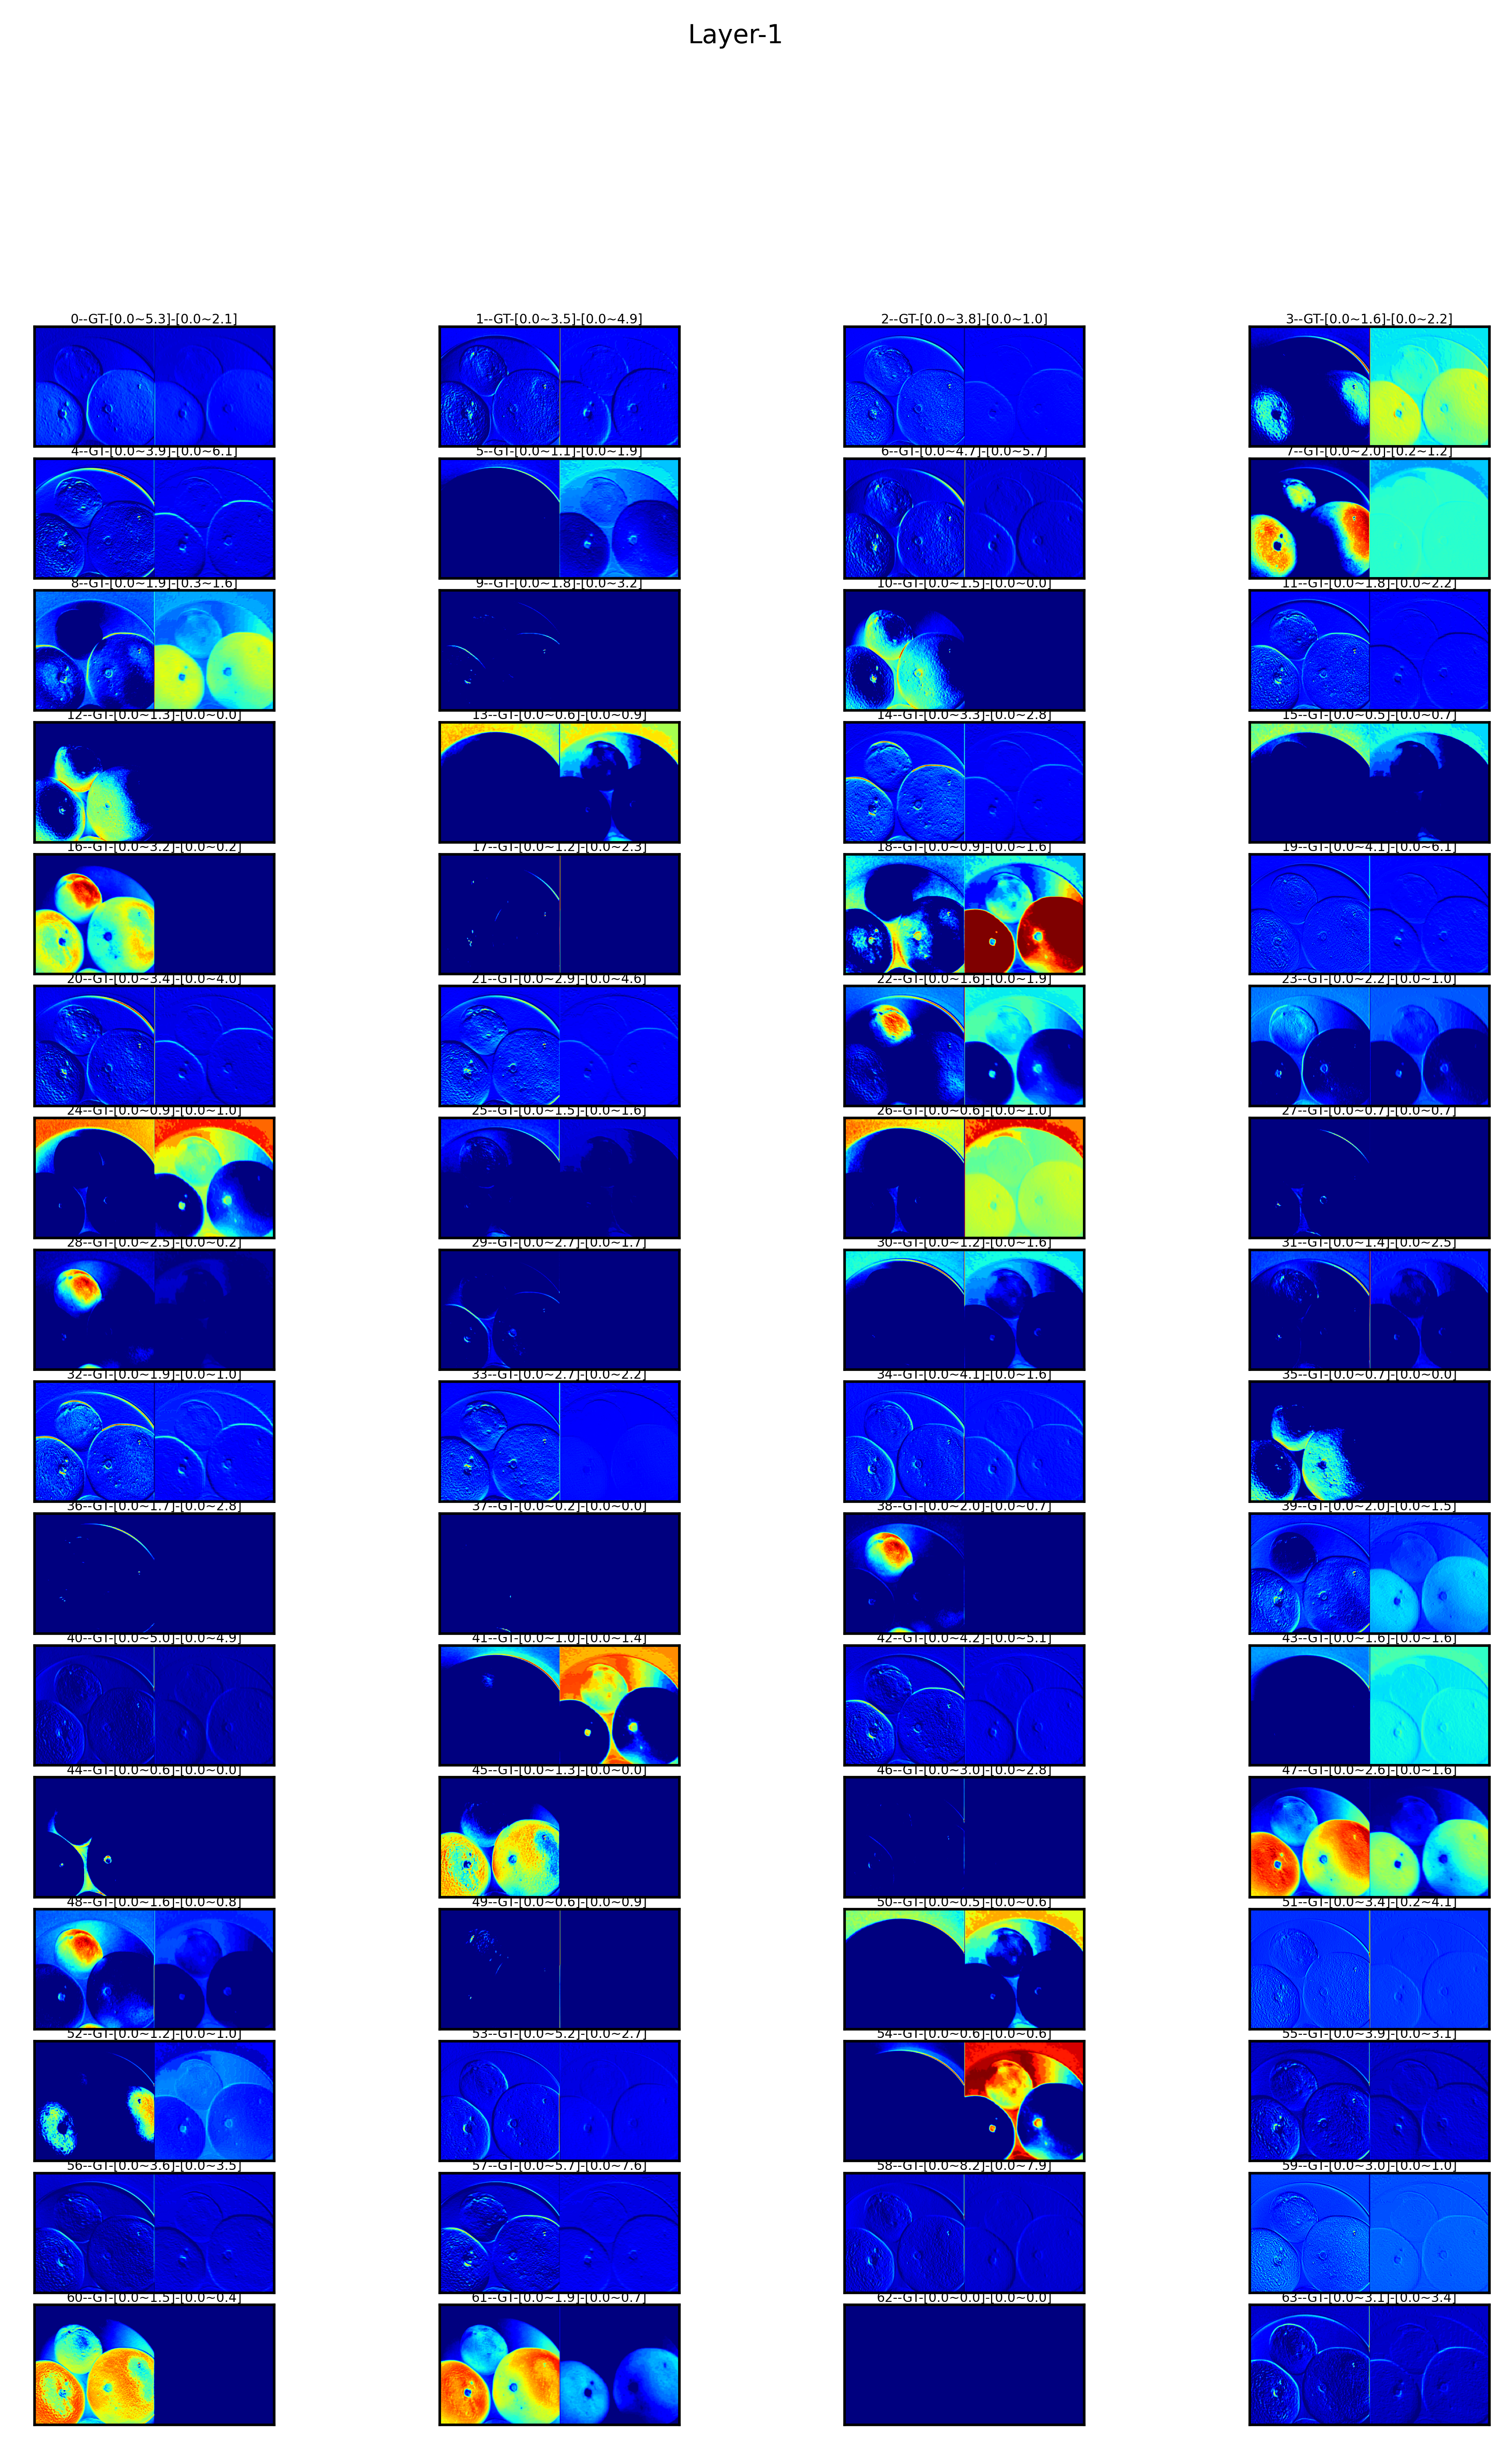

In [17]:
conv_output_indexes_dict = {0:0}
layer_index = 0
layer_name = "1"
ori_activation_maps = net.get_activation_maps(original_image, layer_name)
opt_activation_maps = net.get_activation_maps(opt_image, layer_name)

visualize_features_map_for_comparision(img_index=12, layer_index=layer_index, 
                                       features_map=ori_activation_maps, 
                                       opt_feature_map=opt_activation_maps, 
                                       cols=4, 
                                       conv_output_index_dict=conv_output_indexes_dict, 
                                       save_dict=None, is_save=False,
                                       plt_mode="single", 
                                       color_map = "jet",
                                       layer_name=layer_name)

In [14]:
!ls ../../../saved/pack/052400/80175

ls: cannot access '../../../saved/pack/052400/80175': No such file or directory


In [15]:
path = "../../../saved/pack/052400/80175/80175.npy"
opt_array = np.load(path)
opt_imgs = torch.from_numpy(optimized_data).to(device)

FileNotFoundError: [Errno 2] No such file or directory: '../../../saved/pack/052400/80175/80175.npy'

In [ ]:
opt_imgs == opt_array

In [ ]:
opt_imgs.shape

In [ ]:
opt_array.shape

In [ ]:
conv_output_indexes_dict = {0:0}
layer_index = 0
layer_name = "relu"
ori_activation_maps = net.get_activation_maps(original_image, layer_name)
opt_activation_maps = net.get_activation_maps(opt_imgs, layer_name)

visualize_features_map_for_comparision(img_index=12, layer_index=layer_index, 
                                       features_map=ori_activation_maps, 
                                       opt_feature_map=opt_activation_maps, 
                                       cols=4, 
                                       conv_output_index_dict=conv_output_indexes_dict, 
                                       save_dict=None, is_save=False,
                                       plt_mode="img_scale", 
                                       color_map = "nipy_spectral",
                                       layer_name=layer_name)